In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('./release/')

In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [5]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [6]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [8]:
#gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'
gen_data_path = './data/PI1M.csv'

In [9]:
import warnings

warnings.filterwarnings('ignore')

In [10]:
import json

# 定义字典
word_index = '{"C": 1, "(": 2, ")": 3, "c": 4, "*": 5, "O": 6, "=": 7, "1": 8, "N": 9, "S": 10, "/": 11, "[": 12, "]": 13, "F": 14, "2": 15, "#": 16, "l": 17, "i": 18, "H": 19, "n": 20, "P": 21, "B": 22, "r": 23, "+": 24, "-": 25, "s": 26, "\\\\": 27, "e": 28, "I": 29, "o": 30, "G": 31, "a": 32, "3": 33, "A": 34, "Z": 35, "b": 36, "d": 37, "K": 38, "T": 39, "p": 40, "4": 41}'

# 将字符串转换为字典
word_index_dict = json.loads(word_index)

# 提取键
keys = word_index_dict.keys()

# 打印结果
print(keys)

dict_keys(['C', '(', ')', 'c', '*', 'O', '=', '1', 'N', 'S', '/', '[', ']', 'F', '2', '#', 'l', 'i', 'H', 'n', 'P', 'B', 'r', '+', '-', 's', '\\', 'e', 'I', 'o', 'G', 'a', '3', 'A', 'Z', 'b', 'd', 'K', 'T', 'p', '4'])


In [11]:
# #tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
#           '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
#           '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n','M','*','L','E','a','b','G','K','Z']
tokens = ['<', '>','C', '(', ')', 'c', '*', 'O', '=', '1', 'N', 'S', '/', '[', ']', 'F', '2', '#', 'l', 'i', 'H', 'n', 'P', 'B', 'r', '+', '-', 's', '\\', 'e', 'I', 'o', 'G', 'a', '3', 'A', 'Z', 'b', 'd', 'K', 'T', 'p', '4','M','L','E','5','6','7','8','9','\n','%','0']

In [12]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [13]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

In [16]:
#losses = my_generator.fit(gen_data, 1500000)

In [17]:
#plt.plot(losses)

In [18]:
#my_generator.evaluate(gen_data)

In [19]:
#my_generator.save_model( './checkpoints/generator/checkpoint_polymer_rnn_v1')

In [14]:
my_generator.load_model('./checkpoints/generator/checkpoint_polymer_rnn_v1')

In [15]:
from data import PredictorData
from utils import get_desc, get_fp

In [16]:
import pandas as pd
data_v2=pd.read_csv('/home/cbe/AI4CHEM/polymer_design_v1/ReLeaSE/data/Tensile stress strength at yield v2.csv')

In [17]:
data_v2= data_v2.loc[(data_v2['property_value_median'] < 0.3) & (data_v2['property_value_median'] > 0.0005)]
data_v2 = data_v2 .loc[data_v2['property_value_variance'] < 1e-5]
data_v2=data_v2.reset_index()

In [18]:
data_v2_final=data_v2[['smiles','property_value_median']]

In [19]:
data_v2_final.to_csv('data/Tensile stress strength at yield v2(0.3).csv',index=False)

In [20]:
import pandas as pd
data_ty=pd.read_csv('./data/Tensile stress strength at yield v2(0.3).csv')

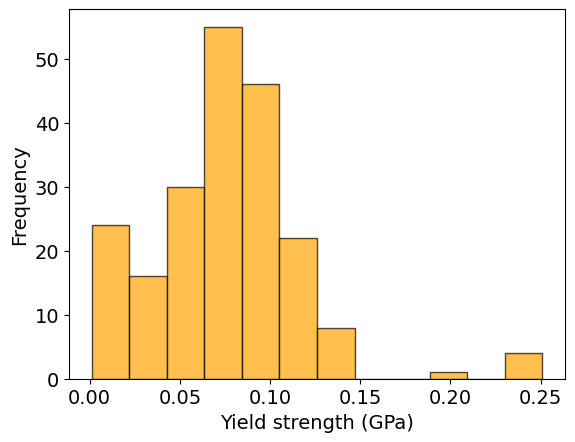

In [21]:
#sns.distplot(df_tensile_modulus_v1['property_value_median'].to_numpy()*1000,color="g")
# sns.distplot(data_ty['property_value_median'].to_numpy()*1000,color='r',
#                  rug=True,
#                  kde=False,
#                  bins=13,
#                  fit=None,
#                  hist_kws={'alpha':0.6,'color':'orange'},
#                  rug_kws={'color':'g'},
#                  norm_hist=False)

plt.hist(data_ty['property_value_median'], bins=12, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Yield strength (GPa)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
#plt.title('Histogram of Yield Strength')
#plt.xlim(0, 0.25)
#plt.show()
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.savefig('yield_strength_histogram_v0403.jpg',dpi=400)

In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem
def get_Morgan_fingerprint_frequency(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
        key=[key for key in info.keys()]
        frq=[len(value) for value in info.values()]
        new_info={key: value for key, value in zip(key, frq)}
        mff=[0] * len(list(fp))
        for key, value in new_info.items():
            mff[key] = value
    except:
        mff=None
    return mff

data_ty['morgan_fp_with_freq'] = data_ty['smiles'].apply(get_Morgan_fingerprint_frequency)

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_ty['morgan_fp_with_freq'].tolist(), data_ty['property_value_median'].tolist(), test_size=0.1, random_state=10)

rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,min_samples_leaf=1, random_state=42)

rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
print('MSE:', mse)
print('R2 score:', r2)
print('MAE:',mae)


MSE: 0.000391197357486477
R2 score: 0.8409751461542392
MAE: 0.012401124285714287


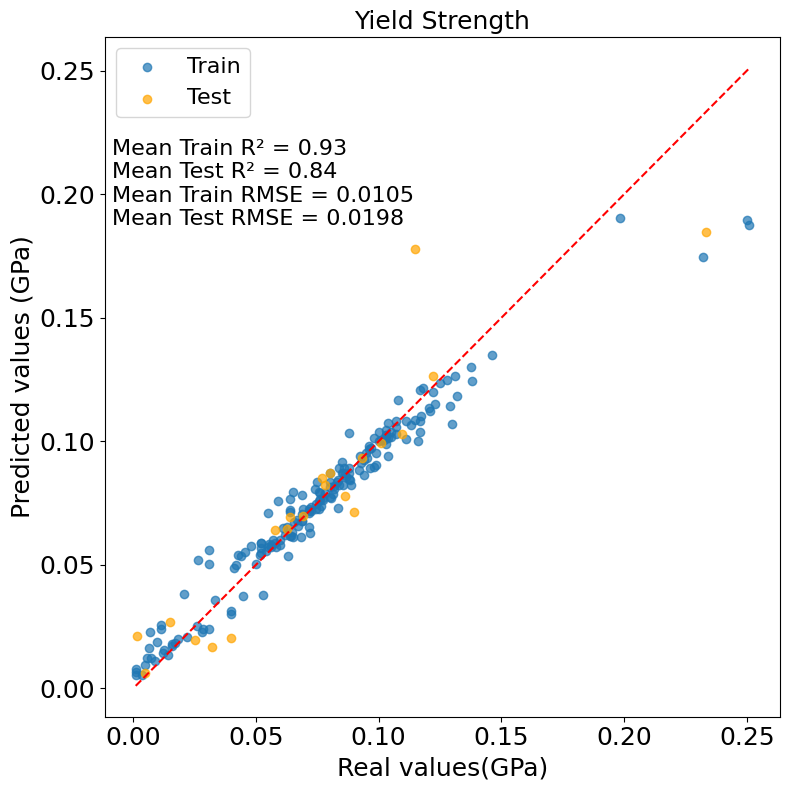

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming your data is already loaded in `data_ty`
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data_ty['morgan_fp_with_freq'].tolist(), 
                                                    data_ty['property_value_median'].tolist(), 
                                                    test_size=0.1, random_state=10)

rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,min_samples_leaf=1, random_state=42)

rf.fit(X_train, y_train)

# Predictions and Metrics for Training Data
y_train_pred = rf.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Predictions and Metrics for Testing Data
y_test_pred = rf.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_pred, label='Train', alpha=0.7)
plt.scatter(y_test, y_test_pred, label='Test', alpha=0.7, color='orange')
plt.plot([min(y_train + y_test), max(y_train + y_test)], 
         [min(y_train + y_test), max(y_train + y_test)], 
         color='red', linestyle='--')


plt.text(0.01, 0.85, 
         f"Mean Train R² = {train_r2:.2f}\n"
         f"Mean Test R² = {test_r2:.2f}\n"
         f"Mean Train RMSE = {train_rmse:.4f}\n"
         f"Mean Test RMSE = {test_rmse:.4f}\n", 
         transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')

plt.tick_params(axis='both', which='major', labelsize=18) 
plt.xlabel("Real values(GPa)", fontsize=18)
plt.ylabel("Predicted values (GPa)", fontsize=18)
plt.title("Yield Strength", fontsize=18)
plt.legend(fontsize=16)
#plt.grid(alpha=0.3)
plt.tight_layout()
#plt.show()
plt.savefig('pair_plot_v0403.jpg',dpi=400)

Text(0.5, 1.0, 'distribution')

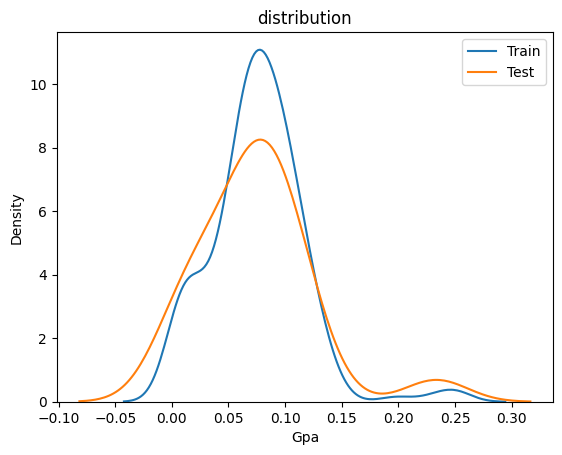

In [26]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.kdeplot(data=np.array(y_train),label='Train')
sns.kdeplot(data=np.array(y_test),label='Test')
plt.legend()
plt.xlabel('Gpa')
plt.title('distribution')

In [27]:
def get_predict_for_new_polymer(smi):
    fp=get_Morgan_fingerprint_frequency(smi)
    fp=np.array(fp)
    result=rf.predict(fp.reshape(1, -1))
    return smi,result

get_predict_for_new_polymer('*C(C(=O)OC)(C*)C')


('*C(C(=O)OC)(C*)C', array([0.01874997]))

In [28]:
class Predictor():
    def __init__(self,model):
        self.model=model

    def get_Morgan_fingerprint_frequency(self,smi):
        try:
            mol = Chem.MolFromSmiles(smi)
            info={}
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
            key=[key for key in info.keys()]
            frq=[len(value) for value in info.values()]
            new_info={key: value for key, value in zip(key, frq)}
            mff=[0] * len(list(fp))
            for key, value in new_info.items():
                mff[key] = value
        except:
            mff=None
        return mff 
    
    def get_predict_for_new_polymer(self,smi):
        fp=self.get_Morgan_fingerprint_frequency(smi)
        fp=np.array(fp)
        result=rf.predict(fp.reshape(1, -1))
        return smi,result
    
    def get_predict_for_new_polymers(self,smi):
        fp_list=[]
        smi_list=[]
        nan_smiles=[]
        for i in smi:
            if Chem.MolFromSmiles(i):
                fp=self.get_Morgan_fingerprint_frequency(i)
                #print(fp)
                fp_list.append(fp) 
                smi_list.append(i)
            else:
                nan_smiles.append(i)
        if len(fp_list)>0:
            result=rf.predict(np.array(fp_list))
        else:
            result=-1
        return smi_list,result,nan_smiles

In [29]:
my_predictor=Predictor(rf)

In [30]:
my_predictor.get_predict_for_new_polymer('*C(C(=O)OC)(C*)C')

('*C(C(=O)OC)(C*)C', array([0.01874997]))

In [31]:
my_predictor.get_predict_for_new_polymers(['*C(C(=O)OC)(C*)C','*CCO*','*CC(F)*','*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

[13:54:16] SMILES Parse Error: syntax error while parsing: *C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1
[13:54:16] SMILES Parse Error: Failed parsing SMILES '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1' for input: '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'


(['*C(C(=O)OC)(C*)C', '*CCO*', '*CC(F)*'],
 array([0.01874997, 0.01647163, 0.03142656]),
 ['*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

In [32]:
my_predictor.get_predict_for_new_polymers(['*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

[13:54:19] SMILES Parse Error: syntax error while parsing: *C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1
[13:54:19] SMILES Parse Error: Failed parsing SMILES '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1' for input: '*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'


([], -1, ['*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1'])

In [33]:
my_predictor.get_predict_for_new_polymers(['*Oc1c(C)cc(C(*)=O)cc1C'])

(['*Oc1c(C)cc(C(*)=O)cc1C'], array([0.06237689]), [])

In [34]:
my_predictor.get_predict_for_new_polymers(['[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1'])

(['[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1'], array([0.12726311]), [])

In [35]:
my_predictor.get_predict_for_new_polymers(['*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1'])

(['*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1'], array([0.14187193]), [])

In [36]:
my_predictor.get_predict_for_new_polymers(['*/C=C/CC(*)c1ccccc1','*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1','*CC(*)CC(=O)c1ccccc1'])

(['*/C=C/CC(*)c1ccccc1',
  '*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1',
  '*CC(*)CC(=O)c1ccccc1'],
 array([0.1050535 , 0.09743345, 0.08740156]),
 [])

In [37]:
my_predictor.get_predict_for_new_polymers(['*/C=C/CC(*)c1ccccc1',
'*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1',
'*CC(*)CC(=O)c1ccccc1',
'*/C=C(/*)Cc1ccccc1',
'*CC(*)C(CCc1ccccc1)c1ccccc1',
'*C=C(*)CCc1ccccc1',
'*CC(*)C(c1ccccc1)c1ccccc1',
'*Nc1ccccc1C(=O)Nc1ccccc1*'])

(['*/C=C/CC(*)c1ccccc1',
  '*CC(*)C(=O)N(CC(=O)c1ccccc1)c1ccccc1',
  '*CC(*)CC(=O)c1ccccc1',
  '*/C=C(/*)Cc1ccccc1',
  '*CC(*)C(CCc1ccccc1)c1ccccc1',
  '*C=C(*)CCc1ccccc1',
  '*CC(*)C(c1ccccc1)c1ccccc1',
  '*Nc1ccccc1C(=O)Nc1ccccc1*'],
 array([0.1050535 , 0.09743345, 0.08740156, 0.08994802, 0.09445285,
        0.08783702, 0.09269385, 0.12060039]),
 [])

In [38]:
my_predictor.get_predict_for_new_polymers(['*c1ccc(N2C(=O)c3ccc(S(=O)(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)cc1'])

(['*c1ccc(N2C(=O)c3ccc(S(=O)(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)cc1'],
 array([0.17994565]),
 [])

In [39]:
my_predictor.get_predict_for_new_polymers(['*Oc1c(C)cc(C(*)=O)cc1C'])

(['*Oc1c(C)cc(C(*)=O)cc1C'], array([0.06237689]), [])

In [40]:
def plot_hist(prediction, n_to_generate):
    #print("Mean value of predictions:", prediction.mean())
    print("Mean value of predictions:", np.mean(prediction))
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted tensile strength at yield ', 
           title='Distribution of predicted yield for generated molecules')
    plt.show()

In [41]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    print(unique_smiles)

    #smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
    smiles,prediction, nan_smiles=predictor.get_predict_for_new_polymers(unique_smiles)                                                 
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

In [42]:
import warnings

warnings.filterwarnings('ignore')

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

Generating molecules...: 100%|██████████| 1000/1000 [00:19<00:00, 51.26it/s]


['*', '**', '**C(=O)Nc1ccc(Sc2ccc(S(=O)(=O)O)cc2)c(C(F)(F)F)c1', '*/C(=C/c1ccccc1)C(*)C(=O)OCCCCCCCC=C', '*/C=C(/*)C(=O)O/C=C/c1ccc(*)cc1C', '*/C=C(/*)CN(CCCCCC)C(=O)OC(C)C', '*/C=C(/*)COCCCC', '*/C=C(/*)COCCOCCOCCOc1ccc(OCc2ccc(/N=N/c3ccccc3)cc2)cc1', '*/C=C(/*)O[Si](C)(C)C', '*/C=C(/*)SOCCOCC[SiH]CCCCCCCCOC(C)OCCOC', '*/C=C(/*)[Si](C)(C)CCCCCCCOC(=O)NCCCC=CCCCCCOC(=O)C(CCC)O*', '*/C=C(\\Cc1cccc(*)c1)c1ccc(/N=N/c2ccc(/N=N/c3ccc(N(C)C)cc3)cc2)cc1', '*/C=C/C(=O)c1ccc(C(C)(C(=O)OC)c2ccc(*)cc2)cc1', '*/C=C/C(C(*)=O)C(=O)OC', '*/C=C/C(C)(C)CFC(=O)NC(=O)C(*)(O[Si](C)(C)C)C(=O)OC', '*/C=C/C(C)C(*)OC(=O)COCCl', '*/C=C/C(COC(=O)C(C)=C(NCCCCC)SC(=O)O*)c1ccccc1', '*/C=C/C1CN(c2ccc(C(=O)OCCCCCCOC(*)=O)cc2)C1=O', '*/C=C/CCC(C#N)C(*)c1ccc(CCCCC)cc1', '*/C=C/CCCC/C=C/CCC[IH]CCCS*', '*/C=C/CCOC(=O)OCCCCOC(=O)OCCCCCCOC(=O)NCCCCCCCCCCNC(=O)OCCCC*', '*/C=C/COCCOc1ccc(S(=O)(=O)c2ccc(OC(=O)Nc3cccc(C)c3)cc2)cc1*', '*/C=C/[Si](*)(CC(F)(F)F)C(F)(F)F', '*/C=C/[Si](C)(C)CCCCNC(=O)c1cccc(*)o1', '*/C=C/c1cc(-c2c

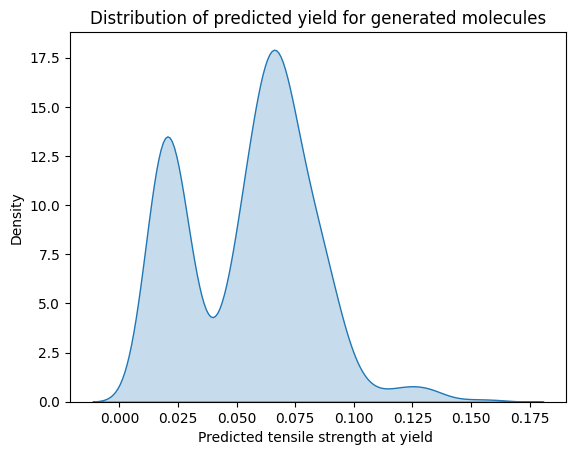

In [43]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=1000)

In [44]:
from reinforcement import Reinforcement

In [45]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/checkpoints/generator/checkpoint_polymer_rnn_v1')

In [46]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 17#100

In [47]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [48]:
def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    #mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    mol, prop, nan_smiles =predictor.get_predict_for_new_polymers([smiles])
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(prop[0]*10.5)

In [49]:
get_reward_max('*C[i](C(=O)Oc1ccc(cSc2ccc(*)cc2)c2ccccc2)cc1', my_predictor, invalid_reward=0.0, get_features=get_fp)

0.0

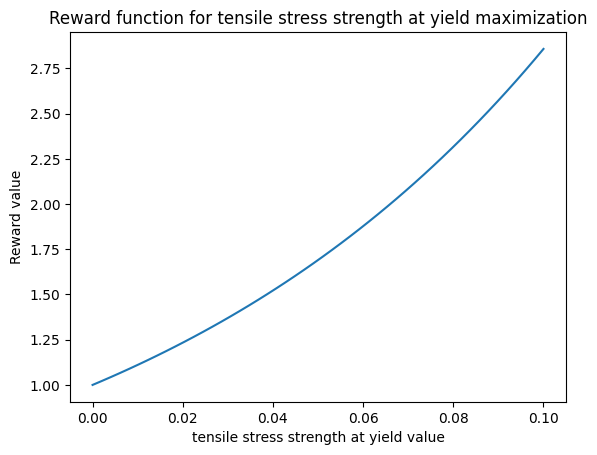

In [50]:
x = np.linspace(0, 0.1)
y = np.exp(x*10.5)
plt.plot(x, y)
plt.xlabel('tensile stress strength at yield value')
plt.ylabel('Reward value')
plt.title('Reward function for tensile stress strength at yield maximization')
plt.show()

In [51]:
RL_max = Reinforcement(my_generator_max, my_predictor, get_reward_max)

In [52]:
rewards_max = []
rl_losses_max = []

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Policy gradient...: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


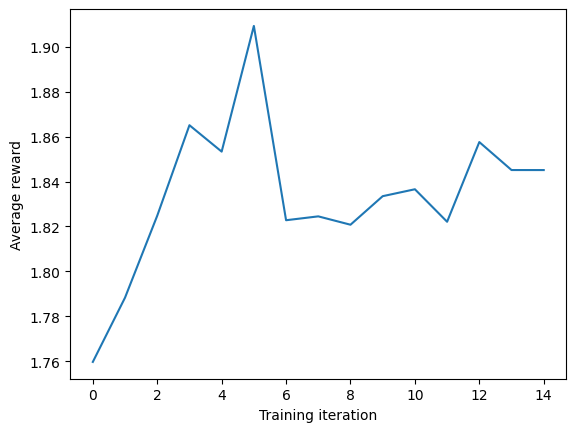

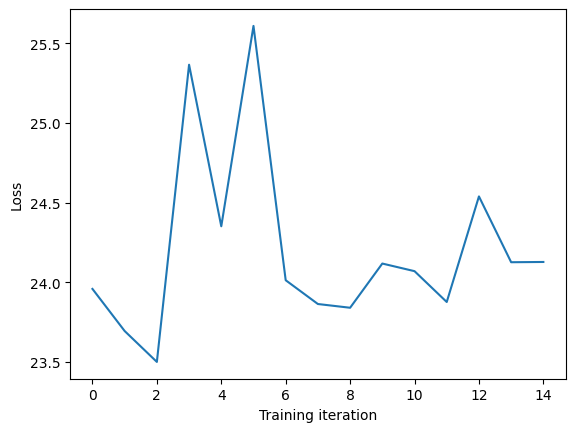

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 47.49it/s]


['*/C=C(/*)C#C[Si](C)(C)CCCCCCCCCC', '*/C=C/C(*)(Cl)C(=O)Nc1ccccc1', '*/C=C/C(=O)CCCC(C)NNC(=O)CCCCCCCCC(*)=O', '*/C=C/C(C)=C(*)CCOc1ccc(OC(=O)c2ccc(C)cc2)cc1', '*/C=C/CCCCC(*)C(=O)OC', '*/C=C/c1cc(OCCCCCCCCCCCCCCCCOC(=O)c2ccccc2)cc(*)c1O', '*C#CCOC(=O)c1ccc(OCCN(CC)c2ccc(O*)cc2)cc1', '*C(*)C(=O)OCC(C)(C)OC(C)CC', '*C(*)OCC(=O)OCC(C)C', '*C(=C)c1ccc(C(*)=O)cc1N', '*C(=O)CCCCCCCCC(=O)OCCOc1cccc(-c2ccc(*)cc2)c1', '*C(=O)CCCCCCCCCCCCCCCCCCC(=O)NC(=O)CCCCCCCCC(*)=Br', '*C(=O)CCNC(*)=O', '*C(=O)c1ccc(NC(=O)CCCCCN(*)c2ccccc2)cc1', '*C(=O)c1cccc(C(=O)Oc2ccc(*)cc2)c1', '*C(=O)c1ccccc1CCOC(=O)c1ccc(N=*)cc1', '*C(C)C(*)(OC(=O)c1ccccc1)Sc1ccccc1', '*C(C)C(=*)COCCN(CC)N(C)CC', '*C=C(*)c1ccccc1CC(O)C(O)OC', '*CC(#N)C(=O)OCCOC(=O)N1CCCC1*', '*CC(*)(C)C(=O)N(CC)CCCCCCCC', '*CC(*)(C)C(=O)OCCCCCCCCCCOC(=O)OCCCCCCCOc1ccc(OC(=O)c2cc(OCC)ccc2*)cc1', '*CC(*)(C)C(=O)OCCCCCCNC(=O)c1ccc(OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)cc1', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(/C=C/c2ccc(/C=C/c3ccc(C(C)(C)C)cc3)cc2)c(C)c1', '

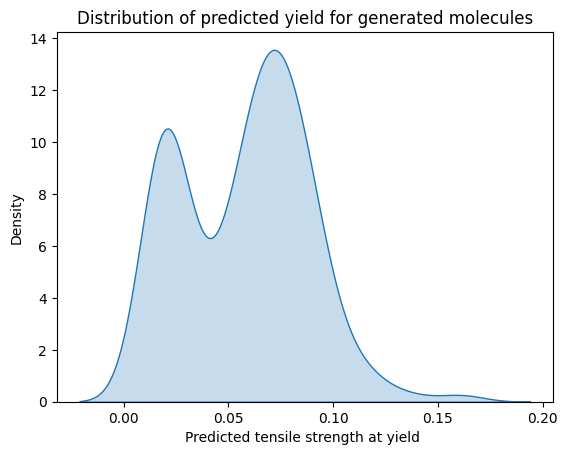

Sample trajectories:
*/C=C(/*)C#C[Si](C)(C)CCCCCCCCCC
*/C=C/C(*)(Cl)C(=O)Nc1ccccc1
*/C=C/C(=O)CCCC(C)NNC(=O)CCCCCCCCC(*)=O
*/C=C/C(C)=C(*)CCOc1ccc(OC(=O)c2ccc(C)cc2)cc1
*/C=C/CCCCC(*)C(=O)OC


Policy gradient...: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


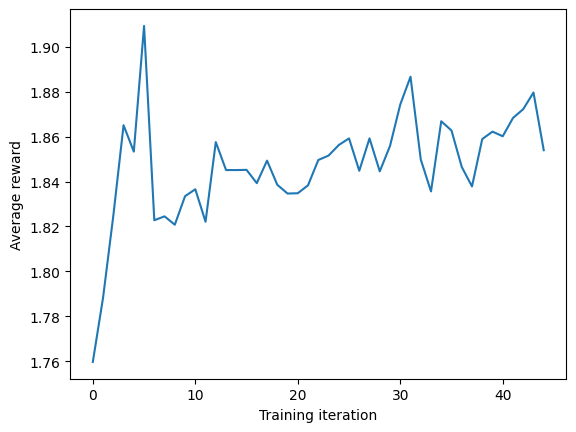

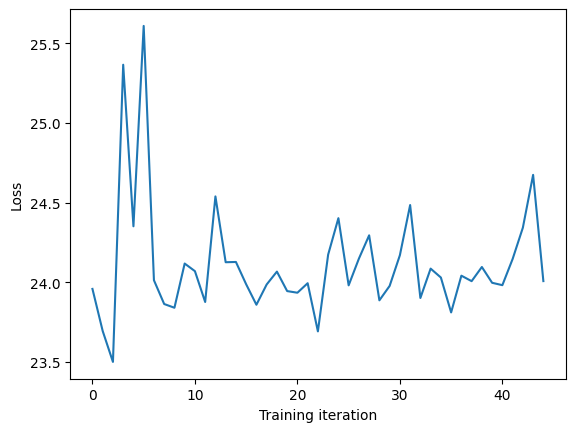

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 50.43it/s]


['**C', '*/C(C)=C(/*)CCCC', '*/C=C(/*)c1ccc(CC(=O)OCC)cc1', '*/C=C/C(=O)Nc1cccc(C(=O)SCCCCCC(*)=O)c1', '*/C=C/C(CCCC)CCCCCCCCCCCCOC(=O)S(*)(=O)=O', '*/C=C/COC(=O)c1ccc(/N=C/c2ccc(C(=O)OCCCCOc3ccc(/N=C/c4ccc(OC)cc4)cc3)cc2)cc1*', '*/C=N/C=C(/*)C#N', '*/C=N/c1cccc(/C=N/c2ccccc2O*)c1', '*C(=O)C(CCOC(=O)COc1ccc(*)cc1)Oc1ccc(CCCCCC)cc1', '*C(=O)C(CCl)=C(*)C(=O)OC', '*C(=O)c1cSc(C(=O)N(CCC)CCN(*)CCCC)cc1', '*C(=O)c1ccc(C(C)(C)c2ccc(C(*)=O)cc2[N+](=O)[O-])c(C)c1', '*C(=O)c1ccc(N(*)CCCCCCCCCCCCCC)cc1', '*C(=O)c1ccc(NC(=O)CCCCCCCCCCC(=O)Nc2ccc(-c3ccc(*)cc3)cc2)cc1', '*C(=S)C(c1ccccc1)c1ccccc1c1ccc(*)cc1[Si](C)(c1ccccc1)c1cccc(C)c1', '*C(CCCCCCCCC)S(*)(=O)=O', '*C/C=C(/*)CCCOc1ccc(/N=N/c2ccc(C#N)cc2)cc1', '*C1CC#C(=*)C1C', '*CC(*)(C(=O)O)=C(C)CF', '*CC(*)(C)C(=O)OC(CC)C(=O)Oc1ccc(Cl)cc1', '*CC(*)(C)C(=O)OCC(C)(C)CC(C)C', '*CC(*)(C)C(=O)OCCCCCCCC(=O)NC(C(=O)Oc1ccccc1OCc1ccccc1)c1ccccc1', '*CC(*)(C)C(=O)OCCCCCCCCCCCCc1ccccc1C(=O)OCCCCCCCCCCOC(=O)c1ccccc1', '*CC(*)(C)C(=O)OCCCCCCCCCOc1ccc(C(=O)c2cc

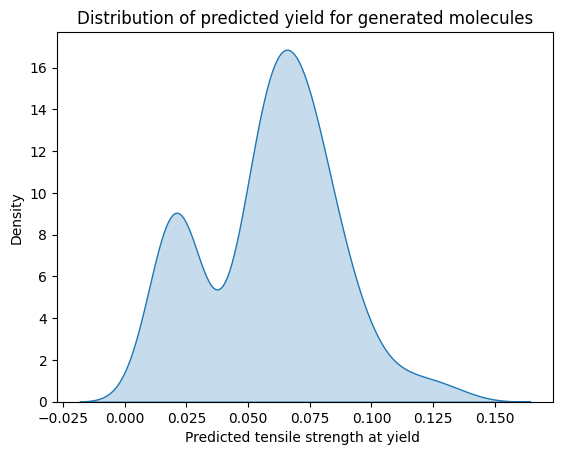

Sample trajectories:
**C
*/C(C)=C(/*)CCCC
*/C=C(/*)c1ccc(CC(=O)OCC)cc1
*/C=C/C(=O)Nc1cccc(C(=O)SCCCCCC(*)=O)c1
*/C=C/C(CCCC)CCCCCCCCCCCCOC(=O)S(*)(=O)=O


Policy gradient...: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


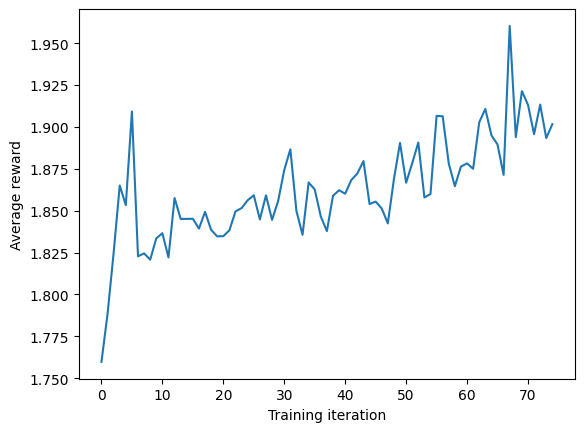

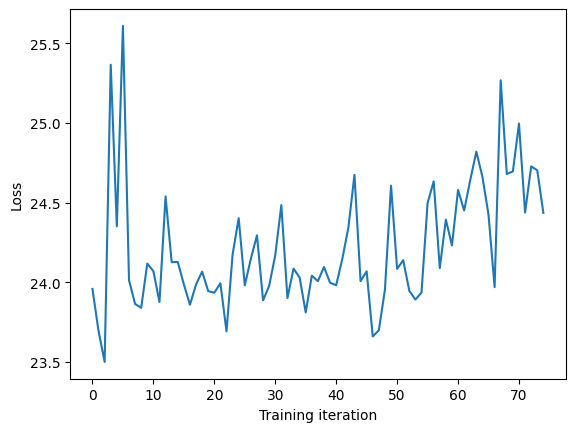

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 44.22it/s]


['*/C=C(/*)c1ccc(CC)cc1C(=O)OC', '*/C=C(/*)c1cccc1', '*/C=C/C(*)OC(=O)c1ccccc1C(=O)OCCCOc1ccc(N(C)C)cc1', '*/C=C/C1CCC(COC(=O)c2cccc(O*)c2)CCN1', '*/C=C/C=C(/*)C#Cc1ccccc1', '*/C=C/C[Si](*)(C)CCCCCCCOc1ccc(OC(=O)c2ccc(C#N)cc2)cc1', '*/C=C/c1c(C)cc(*)cc1-c1ccccc1C(=O)Oc1ccccc1', '*/C=C/c1cc(OCCCCCCCCCCCCCC)cc(*)c1O', '*/C=C/c1ccc(*)c(OCCCCCCCCCCCC)c1-c1ccc([N+](=O)[O-])cc1', '*/C=N/C=C/C(C(=O)NC)=C(*)C(C)C', '*C#CC(CCc1cccc(*)c1)c1ccc(O)cc1', '*C(=*)CC(C)CCCCC', '*C(=O)/C=C(/*)c1ccc(C)cc1', '*C(=O)CCCc1ccc(Cc2ccc(NC(=O)c3ccc(*)cc3)cc2)cc1', '*C(=O)NC(=O)c1cccc(C(=O)c2ccc(c3ccc(-c4ccccc4C(*)=O)c3)cc2)c1', '*C(=O)NNC(=O)c1cccc(C(=O)NCCCNC(=O)c2ccc(*)cc2)c1', '*C(=O)c1c(CC)cc(*)cc1CSCCCCCCCC', '*C(=O)c1ccc(C(=O)c2cccc(C(=O)Nc3ccccc3C(=O)O)c(C(=O)OC(C)(C)C)cc2)c1*', '*C(=O)c1ccc(Oc2ccc(C(=O)Oc3ccc(*)cc3)cc2)cc1', '*C(C(=O)NCCCC)C(*)C(=O)OCC', '*CC(*)(C)C(=O)NCCN(CC)c1ccc(/N=C/c2ccc(OCC)cc2)cc1', '*CC(*)(C)C(=O)OC(=O)c1ccc(Cl)cc1*', '*CC(*)(C)C(=O)OCCCCCCOc1ccc(C(=O)c2ccc(OCCCCCCCCCCCCCCCCC)

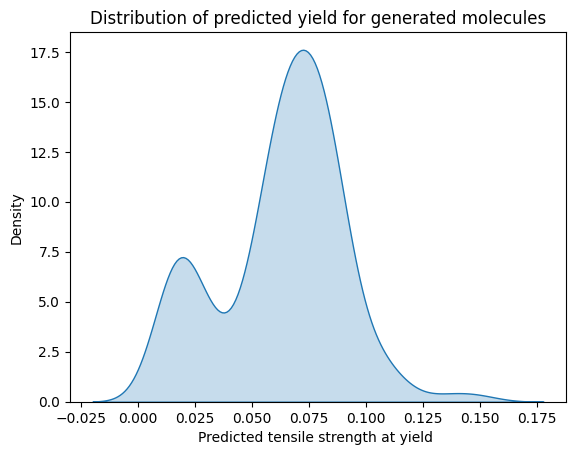

Sample trajectories:
*/C=C(/*)c1ccc(CC)cc1C(=O)OC
*/C=C/C(*)OC(=O)c1ccccc1C(=O)OCCCOc1ccc(N(C)C)cc1
*/C=C/C1CCC(COC(=O)c2cccc(O*)c2)CCN1
*/C=C/C=C(/*)C#Cc1ccccc1
*/C=C/C[Si](*)(C)CCCCCCCOc1ccc(OC(=O)c2ccc(C#N)cc2)cc1


Policy gradient...: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


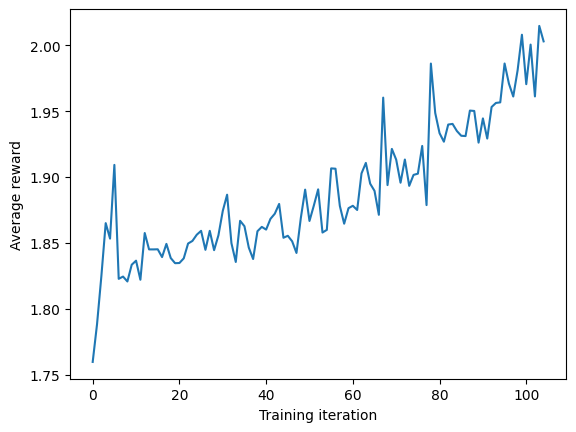

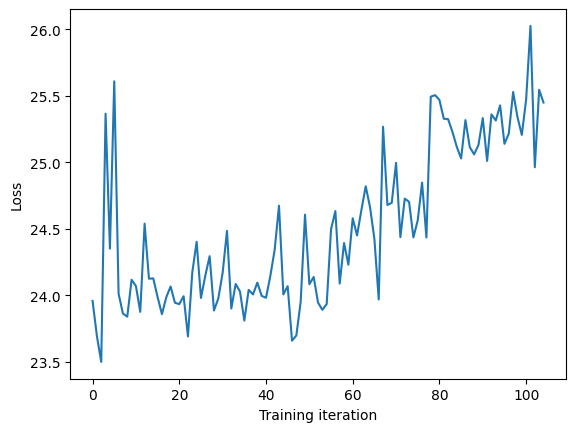

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 48.76it/s]


['*/C=C(/*)c1ccc(C)cc1C', '*/C=C/c1ccc(-c2ccc(*)cc2)cc1OCCCC', '*/C=C/c1ccc(c2ccc(Cc3ccc(NC(=O)c4cccc(C(*)=O)c4)cc3C(F)(F)F)cc2)cc1', '*/N=C/c1ccc(/C=C/c2cc(CC)c(*)cc2[N+](=O)[O-])c(OCC(F)(F)C(F)(F)F)c1', '*/N=N/c1ccc(Sc2ccc([Si](*)(C)O[Si](C)(C)C)cc2)cc1', '*C(*)(CC(=O)OC(C)CCCCCC)NC(=O)c1ccccc1', '*C(=O)C(*)C(=O)OCCCCCCCCCCCCOC(=O)c1ccc(C)cc1C', '*C(=O)CCCCC(=O)OC(=O)c1ccccc1C(=O)Oc1ccccc1CNC(=O)c1ccccc1C(*)=O', '*C(=O)N1CCN(c2ccc(/N=N/c3ccccc3)cc2)C(=O)C1C(=O)N(*)CC(F)(F)CC(F)(F)C(F)(CF)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', '*C(=O)NC(=O)c1ccc(*)cc1C', '*C(=O)c1ccc(-c2ccc(c3ccc(*)cc3)cc2)cc1', '*C(=O)c1ccc(Cc2ccc(Cc3ccc(C(*)=O)c(C(C)C)c3)cc2)cc1', '*C(=O)c1ccc(Cc2ccc(Cc3ccc(C(*)=O)cc3)cc2)cc1', '*C(=O)c1ccc(Cc2ccccc2C(=O)N(*)C#N)cc1', '*C(=O)c1ccc(Nc2ccc(*)cc2)cc1', '*C(=O)c1ccc(Oc2ccc(Oc3ccc(C(*)=O)c(C(=O)OCCCCCCCCCC)c3)cc2)cc1', '*C(=O)c1ccc(Oc2ccc(Sc3ccc(NC(=O)c4ccc(*)cc4)cc3)cc2)cc1C', '*C(=O)c1cccc(C(=O)OC(=O)c2ccccc2*)c1', '*C(=O)c1cccc(C(=O)Oc2ccc(OC(=O)c3ccc(C)c(C(*)=O)c3)cc

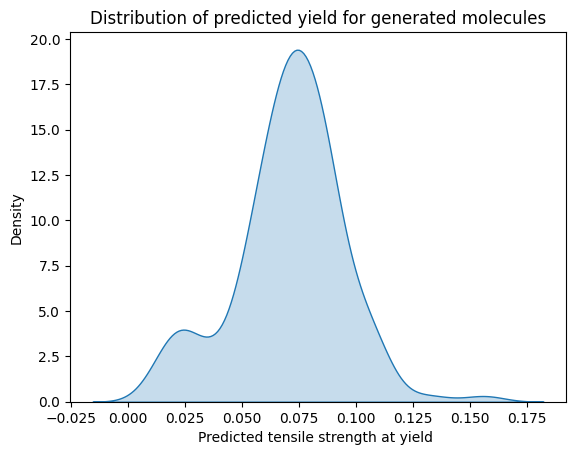

Sample trajectories:
*/C=C(/*)c1ccc(C)cc1C
*/C=C/c1ccc(-c2ccc(*)cc2)cc1OCCCC
*/C=C/c1ccc(c2ccc(Cc3ccc(NC(=O)c4cccc(C(*)=O)c4)cc3C(F)(F)F)cc2)cc1
*/N=C/c1ccc(/C=C/c2cc(CC)c(*)cc2[N+](=O)[O-])c(OCC(F)(F)C(F)(F)F)c1
*/N=N/c1ccc(Sc2ccc([Si](*)(C)O[Si](C)(C)C)cc2)cc1


Policy gradient...: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


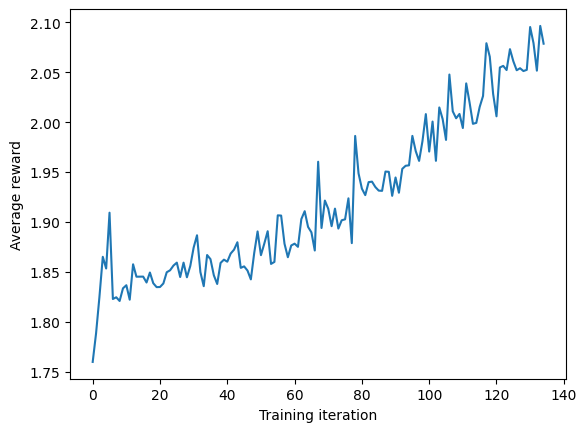

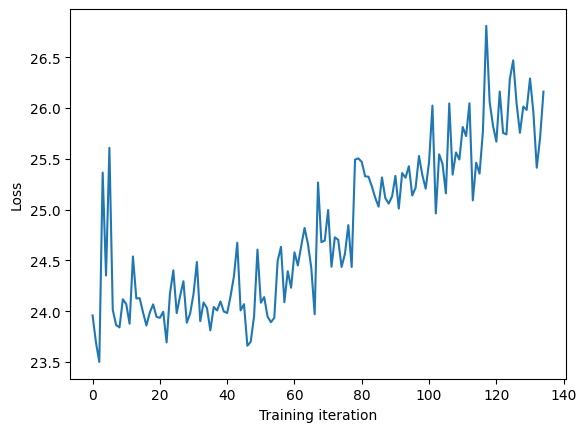

Generating molecules...: 100%|██████████| 200/200 [00:04<00:00, 49.50it/s]


['*/C(C#N)=C(/*)CCCCCCCCCCCCCCC', '*/C=C(\\*)c1ccccc1CCCc1ccccc1', '*/C=C/C=C/c1ccc(*)cc1SCC(CC)CO', '*/C=C/CCCCCCCCCCCCCCCCCCCCCCCCCCCOC(=O)c1ccccc1*', '*/C=C/CNC(=O)CCCCCC(*)=O', '*/C=C/c1ccc(*)cc1CCCCCCCCCCC', '*/C=C/c1ccc(/C=C/c2ccc(*)cc2)cc1OCCCCCC', '*/C=C/c1ccc(C(=O)c2ccc(C(=O)OCC(C)CCNC(*)=O)cc2)cc1', '*/C=C/c1ccc(C(=O)c2ccccc2-c2ccccc2)cc1*', '*C#Cc1ccc(-c2ccc(*)cc2)cc1', '*C(=O)CCCCC(=O)Nc1ccc(Cc2ccc(C(*)=O)cc2)cc1', '*C(=O)NCCc1ccc(OCCOC(=O)c2ccccc2OC(=O)c2ccccc2C(*)=O)cc1', '*C(=O)c1cccc(C(=O)N(*)c2ccccc2)c1', '*C(C#NC(=O)CNCCCCCNC(=O)c1ccn(*)cc1)C(C)C', '*C/C=C(/*)CCCCC(=O)Oc1cccc(OCCC)c1', '*C=C(*)C', '*C=C(Br)c1cccc(NC(=O)c2ccc(C(=O)OCCCCCCCCCCC(*)=O)cc2)c1', '*CC(*)(C)C(=O)OC(C)C(=O)Oc1ccccc1C(F)(F)F', '*CC(*)(C)C(=O)OC(CCCCCCCCCC)c1ccccc1', '*CC(*)(C)C(=O)OCCCCCCCCCCCc1ccc(nc2ccc(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)cc2F)c(OCC([2H])N(*)OC)c1', '*CC(*)(C)C(=O)OCCCCCCCCOc1ccc(C(=O)Oc2cccc(OC)c2)cc1', '*CC(*)(C)C(=O)OCCCCCCCC[N+](C)(C)CCCCC(=O)Nc1ccccc1', '*

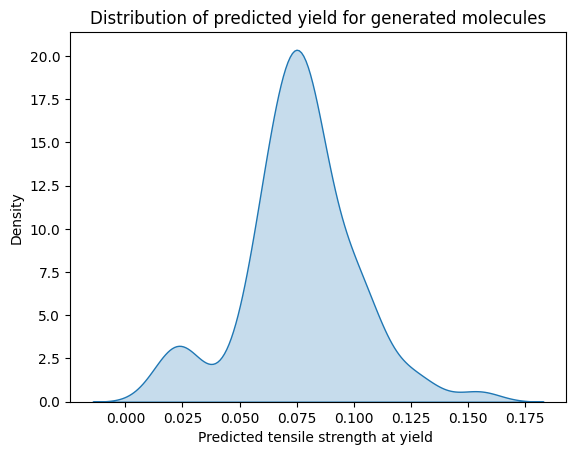

Sample trajectories:
*/C(C#N)=C(/*)CCCCCCCCCCCCCCC
*/C=C(\*)c1ccccc1CCCc1ccccc1
*/C=C/C=C/c1ccc(*)cc1SCC(CC)CO
*/C=C/CCCCCCCCCCCCCCCCCCCCCCCCCCCOC(=O)c1ccccc1*
*/C=C/CNC(=O)CCCCCC(*)=O


Policy gradient...: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


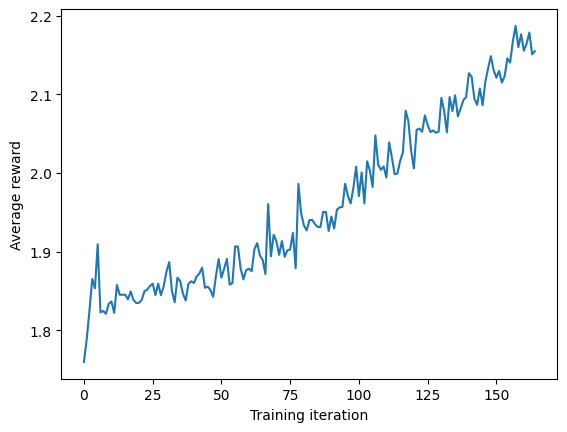

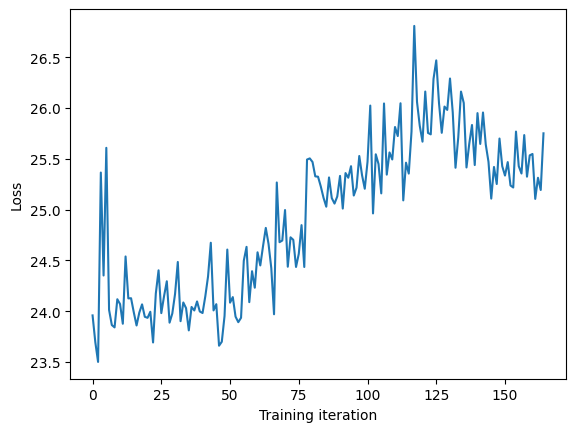

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 55.50it/s]


['*', '**', '**c1ccc(C)cc1C', '*/C=C(/*)CCC[N+](C)(C)C', '*/C=C(/*)c1ccc(C(=O)OCCC)cc1', '*/C=C/C(=O)c1ccccc1-c1ccccc1C(*)=O', '*/C=C/c1cc(OCCC)cc(S(*)(=O)=O)c1', '*/C=C/c1ccc(*)c(OCCOCC(C)C)c1', '*/C=C/c1ccc(N(*)c2ccc(C(=O)OC(C)C)cc2)cc1', '*/C=N/c1ccc(/N=C/c2ccc(N=*)cc2)cc1', '*/C=N/c1ccc(Sc2ccc(OCCCCCCCCC)cc2)cc1*', '*C#Cc1ccc(/C=C/N=C/c2ccccc2)cc1*', '*C#Cc1cccc(COC(*)=O)c1', '*C(*)c1ccccc1C(=O)OCCCCCCCCCCCCC(=O)NCc1ccccc1', '*C(=O)NCCCCCNC(=O)c1cccc(C(*)=O)c1', '*C(=O)c1cc(S(=O)(=O)c2ccccc2)cc(*)c1Oc1ccccc1n1ccccc1c1c(*)ccc1F', '*C(=O)c1ccc(*)cc1C(=O)OCCc1ccccc1', '*C(=O)c1ccc(-c2ccc(NC(=O)c3ccccc3C(=O)c3ccc(*)cc3)cc2)cc1', '*C(=O)c1ccc(C(=O)OCCN(C)CCOC(=O)c2ccc(*)cc2)cc1', '*C(=O)c1ccc(Oc2ccccc2C(=O)Oc2ccc(*)cc2)cc1', '*C(=O)c1ccccc1*', '*C(=O)c1ccccc1C(=O)Oc1ccccc1OCCCCCOC(=O)c1ccccc1OCCOC(=O)c1ccccc1OC(=O)c1ccccc1*', '*C(C=*)OCCCCOc1ccc(O)cc1', '*C/C=C/C(=O)Nc1ccc(Cc2cccc(NC(=O)CCCCCCC(*)=O)c2)cc1', '*C=C(=*)[N+][Si](C)(C)CC', '*CC(*)(C)C(=O)Nc1ccccc1N[Si](C)(CC)c1cccnc1', '*CC

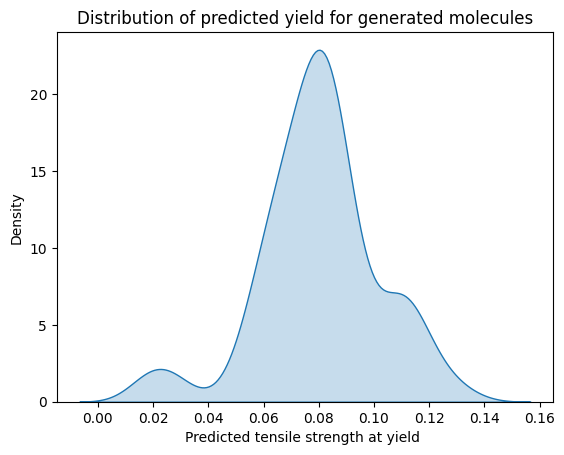

Sample trajectories:
*
**
**c1ccc(C)cc1C
*/C=C(/*)CCC[N+](C)(C)C
*/C=C(/*)c1ccc(C(=O)OCCC)cc1


Policy gradient...: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


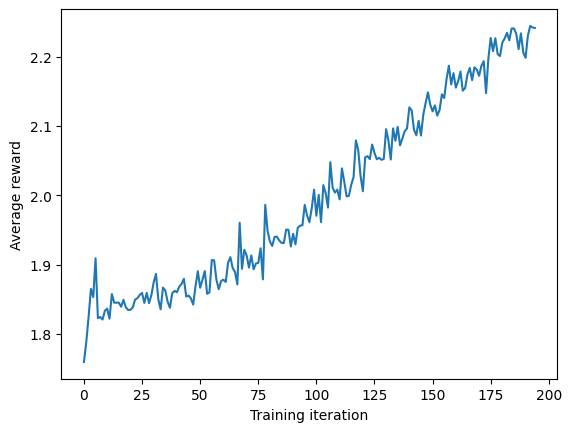

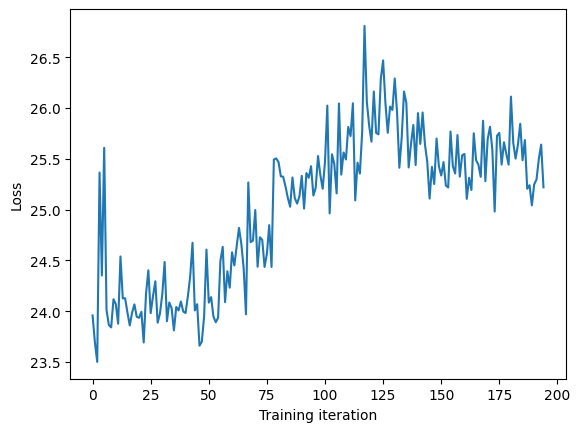

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 56.35it/s]


['*', '*/C=C(/*)c1ccccc1CCc1ccccc1C', '*/C=C/c1ccc(*)cc1', '*/C=C/c1ccc(CCc2ccc(*)cc2Oc2ccccc2)cc1CC', '*/C=C/c1cccc(CCCCCCCCCCCCCCCCOc2ccccc2-c2ccccc2)c1*', '*/C=C/c1ccccc1C(*)=O', '*/C=C/c1ccccc1C=C[Si](*)c1ccccc1', '*/C=C/c1ccccc1COC(=O)c1ccccc1', '*/C=C/c1ccccc1COc1ccccc1C(=O)c1ccccc1C(=O)OCC(=O)SN*', '*/C=N/c1ccccc1COc1ccccc1C(=O)OC(=O)c1ccccc1NC(=O)CCCCC(*)=O', '*/N=N/c1ccccc1Oc1ccccc1*', '*C#Cc1cccc(CNC(=O)CCCCCCCCCCCCC(*)=O)c1', '*C(=C=Nc1ccccc1)C(*)(C)C(=O)Nc1ccccc1', '*C(=O)CCCCCCC(=O)OCCCCCCCCCCCCOc1ccccc1-c1ccccc1*', '*C(=O)Nc1ccccc1NC(=O)c1ccccc1C(=O)OCCOc1ccccc1C(=O)OCCCCCCOC(=O)c1ccccc1C(*)=O', '*C(=O)c1ccc(Cc2ccc(Sc3ccc(C(=O)Nc4ccc(*)cc4)cc3)cc2)c(C)c1O', '*C(=O)c1ccccc1C(=O)OCCCCCCOc1ccccc1C(=O)Oc1ccc(*)cc1', '*C(=O)c1ccccc1CCCCCCC(=O)OC(=O)c1ccccc1C(*)=O', '*C(=S)C(=O)Nc1ccccc1NC(=O)c1ccccc1-c1ccccc1C(=O)Oc1ccc(C(*)OC(=O)c2ccccc2)cc1', '*C*', '*C/C=C/C=C/C=C/c1ccccc1C(*)=O', '*C=C(C)(/C=C/C=C/*)CC', '*CC(*)(C)C(=O)OC(NC(=O)c1ccccc1)Oc1ccccc1', '*CC(*)(C)C(=O)OCCCCCCCC

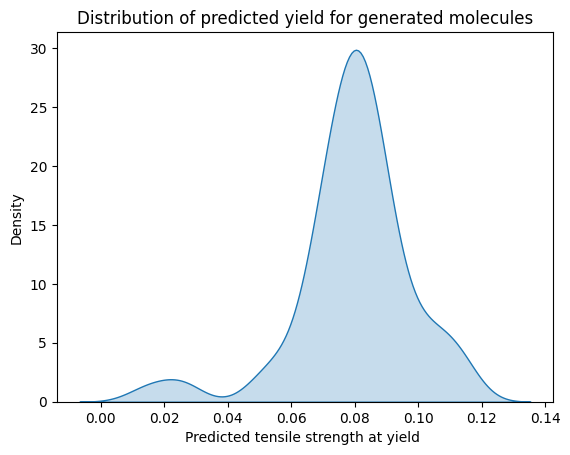

Sample trajectories:
*
*/C=C(/*)c1ccccc1CCc1ccccc1C
*/C=C/c1ccc(*)cc1
*/C=C/c1ccc(CCc2ccc(*)cc2Oc2ccccc2)cc1CC
*/C=C/c1cccc(CCCCCCCCCCCCCCCCOc2ccccc2-c2ccccc2)c1*


Policy gradient...: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


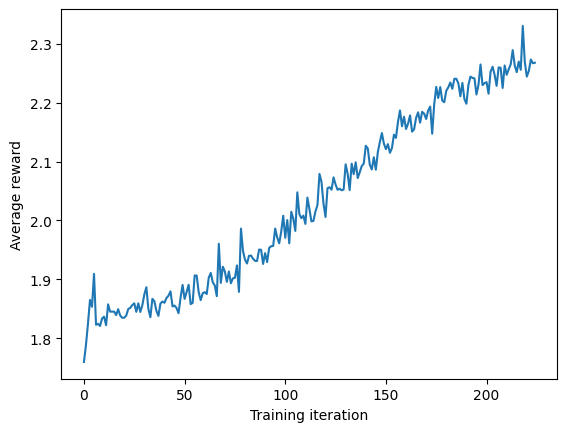

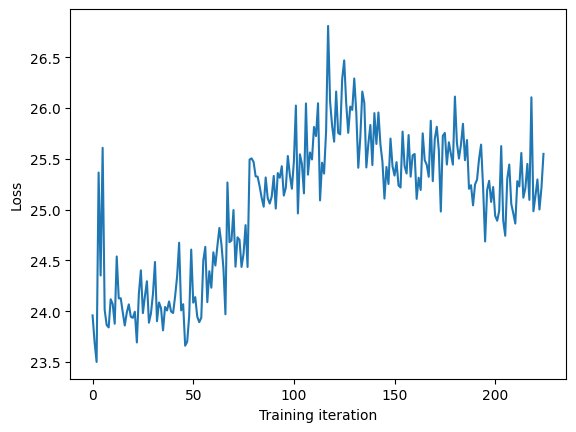

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 54.23it/s]


['**', '*/C=C(/*)C(C=O)c1ccccc1', '*/C=C(/*)c1ccc(C)cc1C', '*/C=C/C(=O)Nc1ccc(NC(=O)CCCCCCCCCCCCCCCCC(=O)Nc2ccccc2C(=O)O)c(*)c1', '*/C=C/C=C(*)C(=O)Oc1ccccc1', '*/C=C/c1ccc(/C=C/C(*)=O)cc1C', '*/C=C/c1cccc(*)c1c', '*/C=C/c1cccc(C(=O)Sc2ccc(*)cc2)c1', '*/C=C/c1cccc(C=*)c1Oc1ccccc1', '*/C=C/c1ccccc1C(*)O', '*/C=N/Cc1ccccc1CCCCCCCNC(*)=O', '*C#CCCCNC(=O)c1ccccc1C(=O)OCCCCCCOc1ccc(/C=N/c2ccc(C(=O)O*)cc2)cc1', '*C(=C=C=*)Nc1ccccc1', '*C(=O)C(c1ccccc1)c1ccccc1*', '*C(=O)NCC(=O)Oc1ccccc1C(=O)OCCCCCCCCCCCCCCc1ccccc1OC(=O)c1ccccc1C(*)=O', '*C(=O)NCCCC(NC(=O)*C)C(=O)OC', '*C(=O)Nc1ccc(Cc2ccc(NC(=O)c3ccccc3)cc2)cc1*', '*C(=O)OCC(C)Nc1ccccc1*', '*C(=O)c1ccccc1-c1ccccc1-c1ccccc1C(*)=N=C', '*C(=O)c1ccccc1-c1ccccc1-c1ccccc1C(=O)OCCOc1ccc(/C=C/c2ccc(*)cc2)cc1', '*C(=O)c1ccccc1C(=O)OCCN(*)c1ccccc1/N=C(/C)c1ccccc1', '*C(=O)c1ccccc1Oc1ccccc1OC(=O)c1ccccc1C(*)=O', '*C(COC(=O)c1ccc(OCc2ccccc2)cc1CCCCCCC)C(*)OC(=O)c1ccccc1', '*C=CC(=O)N(*)CCC', '*CC(*)(C)C(=O)Oc1ccc(-c2ccc(OCCCC)cc2)cc1', '*CC(*)(C)C(=O)Oc1

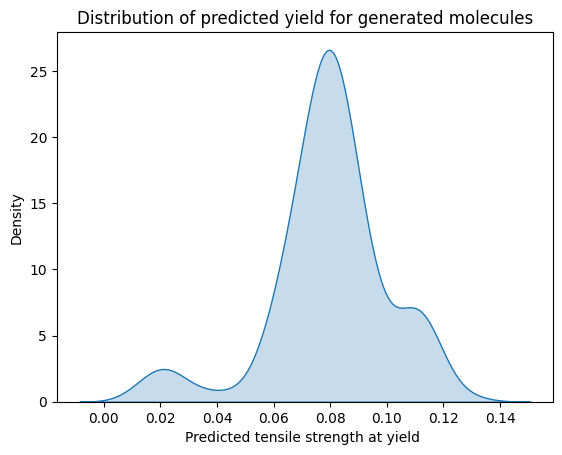

Sample trajectories:
**
*/C=C(/*)C(C=O)c1ccccc1
*/C=C(/*)c1ccc(C)cc1C
*/C=C/C(=O)Nc1ccc(NC(=O)CCCCCCCCCCCCCCCCC(=O)Nc2ccccc2C(=O)O)c(*)c1
*/C=C/C=C(*)C(=O)Oc1ccccc1


Policy gradient...: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


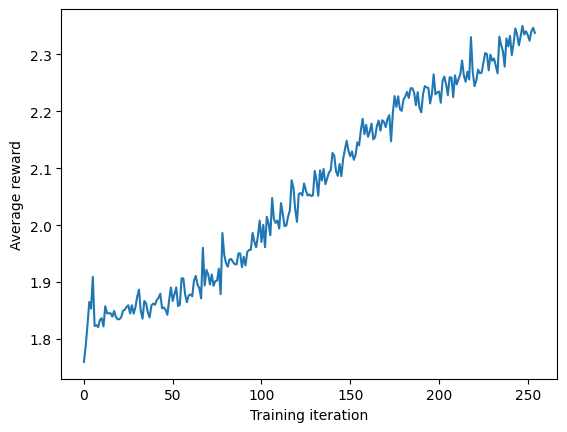

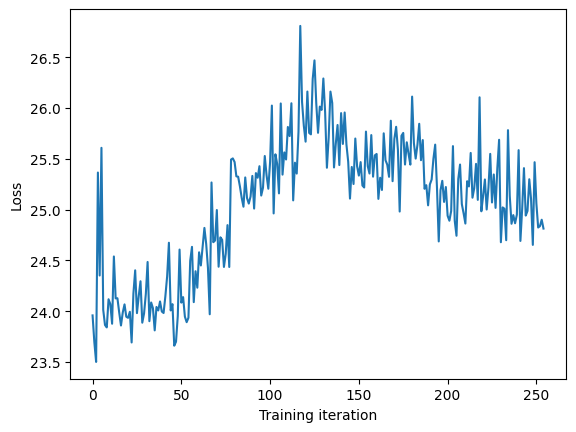

Generating molecules...: 100%|██████████| 200/200 [00:03<00:00, 55.92it/s]


['**', '*/C(=N/c1ccccc1)Oc1ccccc1*', '*/C=C/c1ccc(*)cc1S(=O)(=O)c1ccccc1', '*/C=C/c1ccccc1[Si](*)(C)c1ccccc1', '*/C=N/c1cccc(NC(=O)c2ccccc2C(=O)OCN(C)c2ccc(C(*)=O)cc2)c1', '*/C=N/c1ccccc1(*)(NCC)C(=O)O', '*C', '*C#CC#CC', '*C#CC#CCOc1cccc(C(=O)OCC(C)(C)OC(=O)c2ccc(O*)cc2)cc1', '*C#Cc1ccccc1C#Cc1ccccc1C(=O)O*', '*C(=O)Cc1ccc(-c2ccc(Cc3ccc(C(=O)Oc4ccccc4O*=O)cc3)cc2)cc1', '*C(=O)Nc1cccc(*)c1', '*C(=O)c1ccc(C(=O)NCCC*(C)C)cc1', '*C(=O)c1ccccc1C(=O)NCc1ccccc1NC(=O)c1ccccc1C#*', '*C(=O)c1ccccc1CCc1ccccc1NC(=O)c1ccccc1C(*)=O', '*C(=O)c1ccccc1COc1ccccc1OCc1ccccc1*', '*C(=O)c1ccccc1Nc1ccccc1C(*)=O', '*C(=O)c1ccccc1OC(=O)c1ccccc1NC(=O)c1ccccc1*', '*C/C=C(/*)c1cccc(C/C=C/c2ccccc2)c1', '*CC(*)(C)(=O)C(CC)NC(C)c1ccccc1', '*CC(*)(C)C(=O)OCCCCCCOc1cccc(C(=O)Oc2ccccc2)c1', '*CC(*)(C)C(=O)OCCNC(=O)c1ccc(OC(=O)CC)cc1', '*CC(*)(C)C(=O)OCCOc1cccc(OC)c1', '*CC(*)(C)C(=O)Oc1ccccc1OCCCCCCCCCCCCCCCCCC', '*CC(*)(C)c1ccccc1C(=O)O', '*CC(*)C(=O)Oc1ccccc1C', '*CC(*)C(=O)Oc1ccccc1C(=O)Oc1ccccc1', '*CC(*)C(=O)c1cc

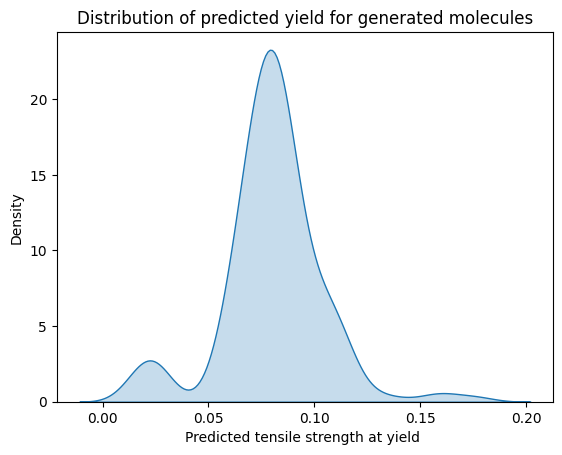

Sample trajectories:
**
*/C(=N/c1ccccc1)Oc1ccccc1*
*/C=C/c1ccc(*)cc1S(=O)(=O)c1ccccc1
*/C=C/c1ccccc1[Si](*)(C)c1ccccc1
*/C=N/c1cccc(NC(=O)c2ccccc2C(=O)OCN(C)c2ccc(C(*)=O)cc2)c1


In [53]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_max.policy_gradient(gen_data, get_features=get_fp)
        rewards_max.append(simple_moving_average(rewards_max, cur_reward)) 
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss))
    
    if i % 2 == 0:
        plt.plot(rewards_max)
        plt.xlabel('Training iteration')
        plt.ylabel('Average reward')
        plt.show()
        plt.plot(rl_losses_max)
        plt.xlabel('Training iteration')
        plt.ylabel('Loss')
        plt.show()
        
        smiles_cur, prediction_cur = estimate_and_update(RL_max.generator, 
                                                        my_predictor, 
                                                        n_to_generate
                                                    )
        
        print('Sample trajectories:')
        for sm in smiles_cur[:5]:
            print(sm)

Generating molecules...: 100%|██████████| 10000/10000 [02:54<00:00, 57.43it/s]


['*', '*#N', '*#Nc1ccccc1NC(=O)c1ccccc1C(=O)NCCc1ccccc1', '**', '**#Nc1ccccc1C', '**C#Nc1ccccc1', '**C(=O)c1ccc(OCC)cc1', '**Oc1ccccc1CCCCCCCNC(=O)c1ccccc1CCC(=O)Oc1ccccc1', '**Oc1ccccc1CCSCCCCCCC=Cc1ccccc1', '**c1cccc(C(=O)c2ccccc2)c1', '**c1ccccc1#N', '**c1ccccc1-c1ccccc1', '**c1ccccc1O', '*/C(=C/c1ccccc1)Oc1ccc(C(C)(C)c2cccc(*)c2)cc1', '*/C(=N/c1ccc(*)cc1)c1ccccc1', '*/C(=N/c1ccccc1)C(*)c1ccccc1', '*/C(=N/c1ccccc1)C(CC(F)(F)F)C(F)(F)C(F)(F)F', '*/C(=N/c1ccccc1)c1ccccc1*', '*/C(=N/c1ccccc1)c1ccccc1Nc1ccccc1N(*)c1ccccc1', '*/C(C#N)=C(\\N)Cc1cccc(*)c1', '*/C(C#N)=N/c1ccccc1CCCCc1ccccc1NC(=O)c1ccccc1*', '*/C(C)=C(/*)c1ccccc1O', '*/C(C)=C/c1ccc(*)cc1N', '*/C(C)=C/c1cccc(*)c1', '*/C=C(/*)CCC(=O)N/C=C/c1ccccc1', '*/C=C(/*)CCCN(C)c1ccccc1', '*/C=C(/*)CCCOc1ccc(OC(=O)c2ccc(OC)cc2)cc1', '*/C=C(/*)CCCSSSC', '*/C=C(/*)CCSC(=O)c1ccc(C(=O)Oc2ccc(OC)cc2)cc1', '*/C=C(/*)COc1ccc(C(=O)c2ccccc2)cc1', '*/C=C(/*)Nc1ccccc1', '*/C=C(/*)OCc1ccccc1', '*/C=C(/*)Oc1cccc(OC(=O)c2ccccc2)c1', '*/C=C(/*)Sc1ccccc1

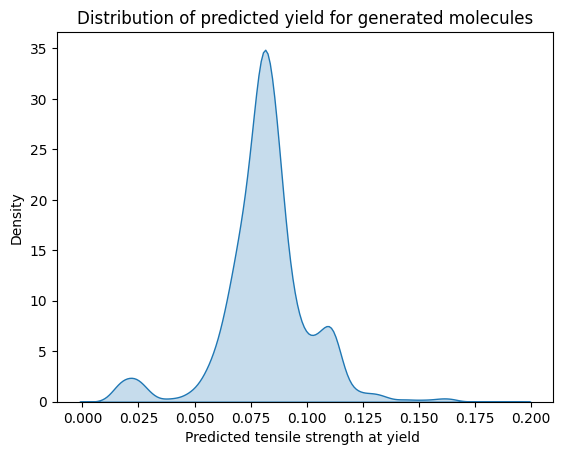

In [ ]:
### Because the randomness of the generator, the results may vary a bit between runs.
smiles_biased_max, prediction_biased_max = estimate_and_update(RL_max.generator, 
                                                           my_predictor,
                                                           n_to_generate=10000)

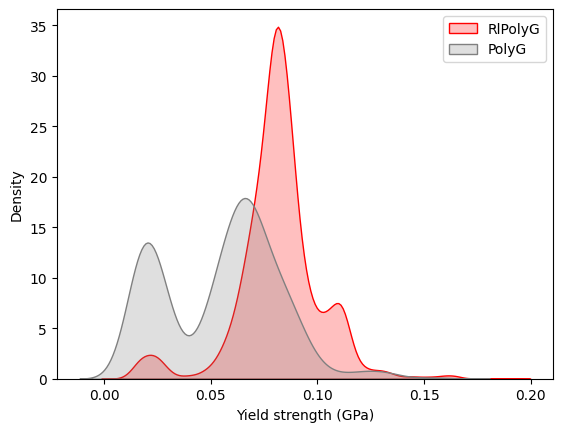

In [55]:
sns.kdeplot(prediction_biased_max,label='RlPolyG', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='PolyG', shade=True, color='grey')
plt.xlabel('Yield strength (GPa)')
plt.legend()
plt.show()

In [61]:
import pandas as pd
df_generate = pd.DataFrame({'SMILES': smiles_biased_max, 'Tensile stress strength at yield': prediction_biased_max})

In [59]:
PI1M=pd.read_csv('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/data/PI1M_v2.csv')

def get_standard_smiles(smi):
    new_mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    return smiles
    
PI1M['standard_SMILES']=PI1M['SMILES'].apply(get_standard_smiles)

PI1M_list= PI1M['standard_SMILES'].to_numpy()
def judege_new_polymer(smi):
    new_mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    if smiles not in PI1M_list:
        i=1
    else:
        i=0
    return i

In [86]:
polyinfo=pd.read_excel('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/proprety_predict/RESULT.xlsx')

def get_standard_smiles(smi):
    #print(smi)
    try:
        new_mol = Chem.MolFromSmiles(smi)
        smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    except:
        smiles=smi
    return smiles

polyinfo['standard_SMILES']=polyinfo['SMILES'].apply(get_standard_smiles)

polyinfo_list= polyinfo['standard_SMILES'].to_numpy()
def judege_new_polymer_polyinfo(smi):
    
    new_mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(new_mol, isomericSmiles=True, canonical=True)
    if smiles not in polyinfo_list:
        i=1
    else:
        i=0
    return i

In [87]:
judege_new_polymer('*Nc1ccc(C(=O)c2ccc(C(*)=O)cc2C)cc1')

1

In [88]:
judege_new_polymer_polyinfo('*Oc1c(C)cc(C(*)=O)cc1C')

1

In [145]:
df_generate['standard_SMILES']=df_generate['SMILES'].apply(get_standard_smiles)

In [146]:
df_generate['novelty']=df_generate['standard_SMILES'].apply(judege_new_polymer)
df_generate['polyinfo_novelty']=df_generate['standard_SMILES'].apply(judege_new_polymer_polyinfo)

In [ ]:
df_generate=df_generate.sort_values(by='Tensile stress strength at yield',ascending=False)
df_generate
#df_generate.to_csv('RLPolyG_tensile_stress_strength_at_yield_v0625.csv',index=False)

In [57]:
import pandas as pd
df_generate=pd.read_csv('RLPolyG_tensile_stress_strength_at_yield_v0625.csv')

In [58]:
novelty_count = df_generate['novelty'].value_counts()
polyinfo_novelty_count = df_generate['polyinfo_novelty'].value_counts()

both_novelty_count = df_generate[(df_generate['novelty'] == 1) & (df_generate['polyinfo_novelty'] == 1)].shape[0]

print("PI1M novelty:")
print(novelty_count)
print("PI1M novelty ratio:",(novelty_count[1])/len(df_generate))

print("Polyinfo novelty:")
print(polyinfo_novelty_count)
print("polyinfo novelty ratio:",(polyinfo_novelty_count[1])/len(df_generate))

print("Total novelty:")
print(both_novelty_count)
print("Total novelty ratio:",both_novelty_count/len(df_generate))

PI1M novelty:
novelty
1    5175
0    1684
Name: count, dtype: int64
PI1M novelty ratio: 0.7544831608106138
Polyinfo novelty:
polyinfo_novelty
1    6616
0     243
Name: count, dtype: int64
polyinfo novelty ratio: 0.9645720950575886
Total novelty:
4991
Total novelty ratio: 0.7276570928706808


In [59]:
from canonicalize_psmiles.canonicalize import canonicalize
smiles = "*Nc1ccc(NC(*)=O)cc1"
print(smiles)
print(canonicalize(smiles))

*Nc1ccc(NC(*)=O)cc1
[*]Nc1ccc(NC([*])=O)cc1


In [60]:
df_PI1M_v2=pd.read_csv('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/data/PI1M_v2.csv')
df_PI1M_v2['yield_strength']=df_PI1M_v2['SMILES'].apply(my_predictor.get_predict_for_new_polymer)

In [61]:
df_PI1M_v2['yield_strength1'] = df_PI1M_v2['yield_strength'].apply(lambda x: x[1][0])

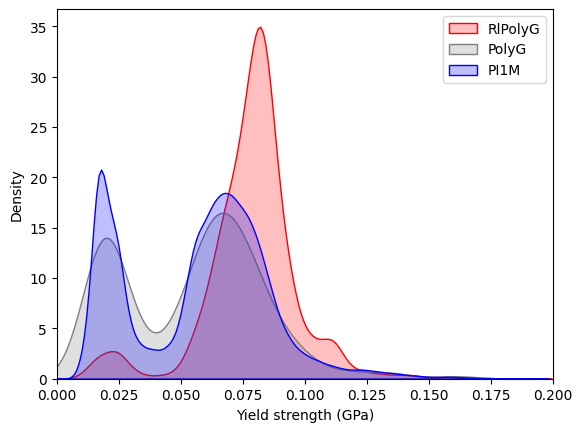

In [64]:
sns.kdeplot(prediction_biased_max,label='RlPolyG', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='PolyG', shade=True, color='grey')
sns.kdeplot(df_PI1M_v2['yield_strength1'], label='PI1M', shade=True, color='blue')
plt.xlabel('Yield strength (GPa)')
plt.legend()
#plt.show()
plt.xlim(0,0.2)
plt.savefig('Yield strength distribution.png',dpi=300)

In [65]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.jointplot(x='yield_strength1', y='SA Score',data= df_PI1M_v2, 
              kind="kde",
)
plt.show()

##### SAscore is used to  estimate how hard (10.000) or how easy (1.000) it may be to synthesize a given molecule.
We use an SA score <5.000 as a criterion for selecting candidate p-SMILES for further validation

In [126]:
import sys
sys.path.append('./proprety_predict/')

from SAscore import sa_score

In [127]:
df_generate['SAscore']=df_generate['SMILES'].apply(sa_score) 

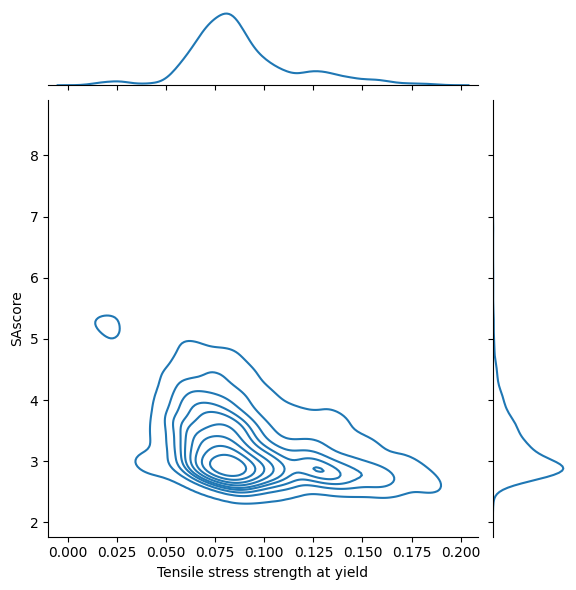

In [67]:
sns.jointplot(x='Tensile stress strength at yield', y='SAscore',data= df_generate, 
              kind="kde",
)
plt.show()

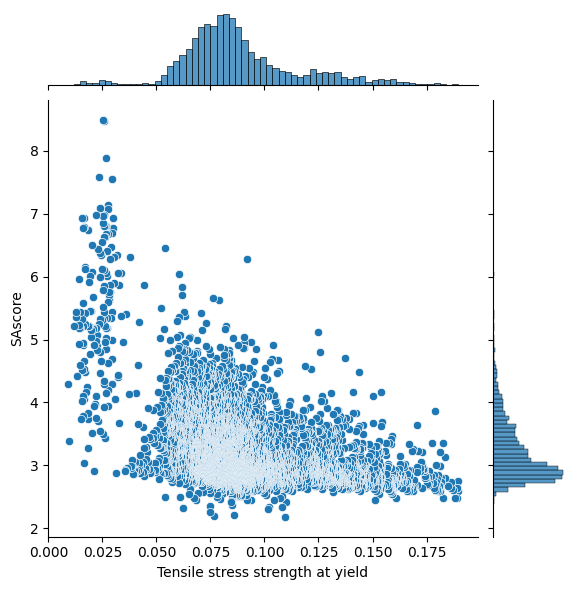

In [76]:
sns.jointplot(x='Tensile stress strength at yield', y='SAscore',data= df_generate)

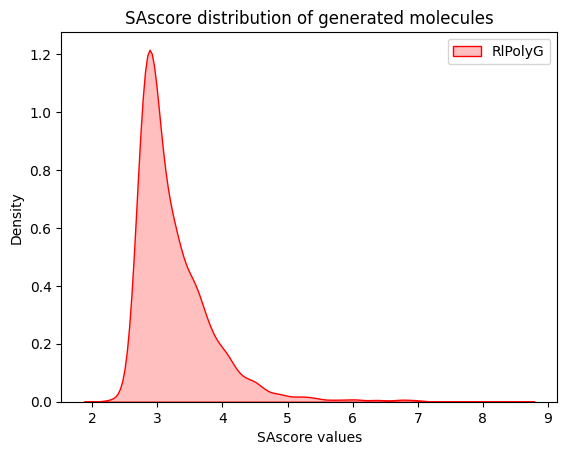

In [68]:
sns.kdeplot(df_generate['SAscore'],label='RlPolyG', shade=True, color='red')
plt.xlabel('SAscore values')
plt.legend()
plt.title('SAscore distribution of generated molecules')
plt.show()

In [251]:
sa_score('*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1')

2.9464358126097867

In [252]:
sa_score('[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1')

2.9250326205620496

In [60]:
sa_score('*Oc1c(C)cc(C(*)=O)cc1C')

3.8496361300993236

In [61]:
df_PI1M_v2=pd.read_csv('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/data/PI1M_v2.csv')

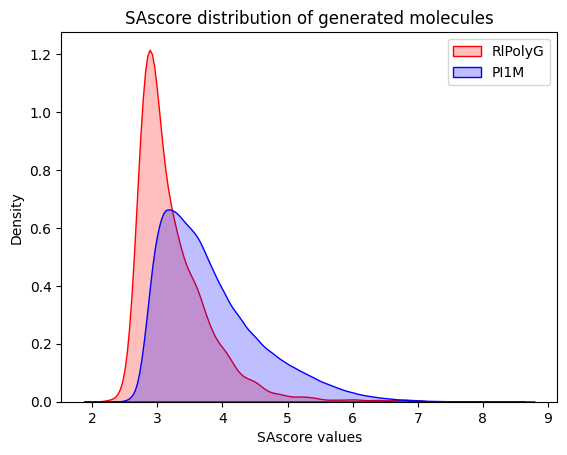

In [254]:
sns.kdeplot(df_generate['SAscore'],label='RlPolyG', shade=True, color='red')
sns.kdeplot(df_PI1M_v2['SA Score'],label='PI1M', shade=True, color='blue')
plt.xlabel('SAscore values')
plt.legend()
plt.title('SAscore distribution of generated molecules')
plt.show()

In [128]:
import pickle
with open('/home/cbe/AI4CHEM/polymer_design/ReLeaSE/proprety_predict/rf_mfp_degradability.pkl', 'rb') as f:
    rf_degradability = pickle.load(f)

In [129]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
def get_Morgan_fingerprint_frequency(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
        key=[key for key in info.keys()]
        frq=[len(value) for value in info.values()]
        new_info={key: value for key, value in zip(key, frq)}
        mff=[0] * len(list(fp))
        for key, value in new_info.items():
            mff[key] = value
    except:
        mff=None
    return mff

def get_degradability_predict(smi):
    X_screen=get_Morgan_fingerprint_frequency(smi)
    #print(X_screen)
    X_screen=np.reshape(X_screen,(1,-1))
    pred=rf_degradability.predict(X_screen)
    pred=pred[0]
    return pred 

In [32]:
get_degradability_predict('*Nc1ccc(-c2ccc(C(*)=O)cc2)cc1')

0.47618254523374776

In [78]:
get_degradability_predict('[*]Nc1ccc(Oc2ccc(C([*])=O)cc2)cc1')

0.4084858145571716

In [101]:
get_degradability_predict('[*]Nc1ccc(NCc2ccc(C([*])=O)cc2)cc1')

0.4627646725059676

In [84]:
get_degradability_predict('*c1ccc(N2C(=O)c3ccc(S(=O)(=O)c4ccc5c(c4)C(=O)N(*)C5=O)cc3C2=O)cc1')

0.6737830075560793

In [6]:
get_degradability_predict('*Oc1c(C)cc(C(*)=O)cc1C')

0.7675836004363015

In [140]:
get_degradability_predict('*Nc1ccc(NC(=S)c2ccc(C(*)=O)cc2)cc1')

0.4117832037325644

In [153]:
# data_add_MD=pd.read_excel('/home/cbe/AI4CHEM/polymer_design_v1/ReLeaSE/RLPolyG_ADD_MD_0625.xlsx')

In [151]:
# data_add_MD['standard_SMILES']=data_add_MD['SMILES'].apply(get_standard_smiles)
# data_add_MD['novelty']=data_add_MD['standard_SMILES'].apply(judege_new_polymer)
# data_add_MD['polyinfo_novelty']=data_add_MD['standard_SMILES'].apply(judege_new_polymer_polyinfo)

In [154]:
#data_add_MD

In [93]:
#data_add_MD['degradability']=data_add_MD['SMILES'].apply(get_degradability_predict)

In [143]:
#data_add_MD['SAScore']=data_add_MD['SMILES'].apply(sa_score) 

In [130]:
df_generate['degradability']=df_generate['SMILES'].apply(get_degradability_predict)

In [131]:
#df_generate.to_csv('RLPolyG_tensile_stress_strength_at_yield_v0625.csv',index=False)

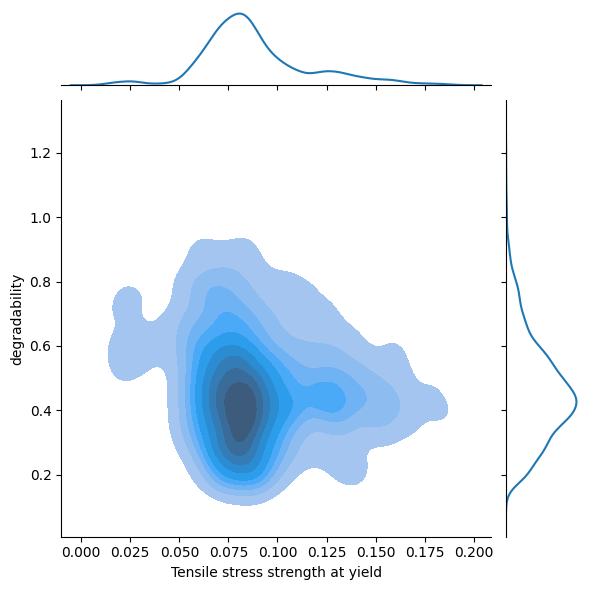

In [74]:
sns.jointplot(x='Tensile stress strength at yield', y='degradability',data= df_generate, 
              kind="kde",
              shade = True
)
plt.show()

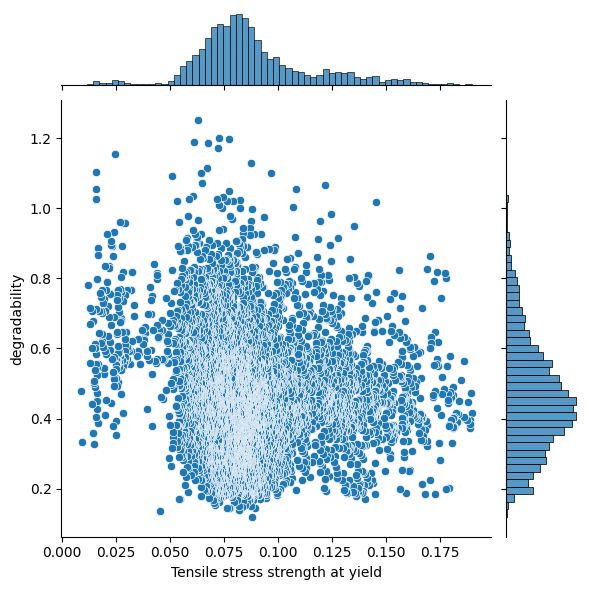

In [75]:
sns.jointplot(x='Tensile stress strength at yield', y='degradability',data= df_generate)

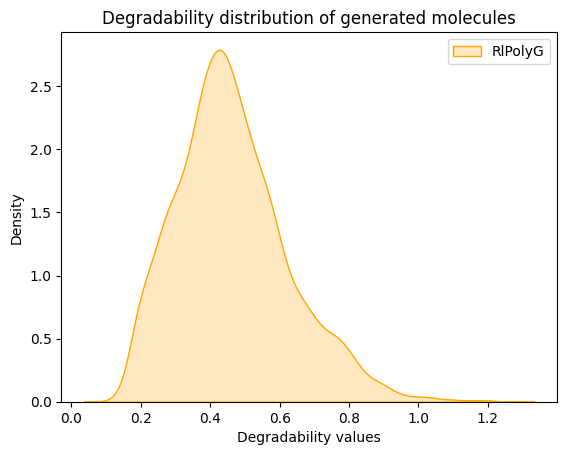

In [73]:
sns.kdeplot(df_generate['degradability'],label='RlPolyG', shade=True, color='orange')
plt.xlabel('Degradability values')
plt.legend()
plt.title('Degradability distribution of generated molecules')
plt.show()

In [261]:
df_PI1M_v2['degradability']=df_PI1M_v2['SMILES'].apply(get_degradability_predict)

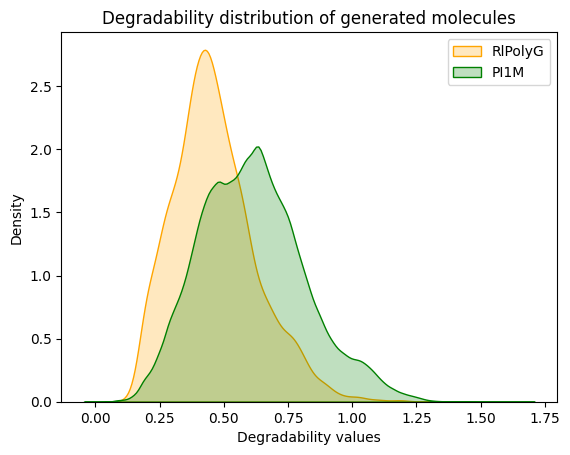

In [263]:
sns.kdeplot(df_generate['degradability'],label='RlPolyG', shade=True, color='orange')
sns.kdeplot(df_PI1M_v2['degradability'],label='PI1M', shade=True, color='green')
plt.xlabel('Degradability values')
plt.legend()
plt.title('Degradability distribution of generated molecules')
plt.show()

In [207]:
# df_generate_sort = df_generate.sort_values('Tensile stress strength at yield', ascending=False)
# df_generate_sort.to_csv('df_generate_sort.csv',index=False)